# Executive Summary

This full example is meant to implement how the digital twin abstract class is supposed to be useful and work. It will show what needs to be done on the model end as well as what gets used on the digital twin abstract class end.

The directory for this model is "model2"

Everything here would be what should be going into a dt.py file that would create the digital twin framework.

# 1. Data Pipelines

# Model Specific

## Types

Under types, there is definitions for all types that are to be used in the system. Copious typing should be done, and for all data types with both raw/processed there should be a type.

## Data

While there is data processing functions, these are supposed to be light data functions and any hardcode data processing should be through a data infrastructure. The functions will be of the following categories, where N is a variable number of data pulls, and brackets will show how many of any given type there should be.

1. [1+] Data Connection Method: A method for how to connect to the database. Input: None Output: Connection
2. [N] Raw Data Pulls: Pulls that directly hit the data infrastructure held database tables. Input: Connection Output: Raw Data Type
3. [N] Data Processing: Any light data processing such as doing pivots since holding a pivot table would be space ineffecient on the SQL side. Input: Raw Data Type Output: Processed Data Type
4. [1] Backtest Data Pull: A pull that combines all raw pulls and data processing pulls, plus connects to the database and returns a Backtest Data Type. Input: None Output: Backtest Data Type
5. [1] Input Data Computation: A processing function that takes backtest data and then returns starting state, the historical data, the input data (what goes into the backtest) and the output data (what is being used to validate the backtest). Input: Backtest Data Type Output: Input Data Type
6. [1] Format Inputs: One function which takes the input data and formats the input into data classes for use within cadCAD.

# Digital Twin Specific

1. A DataPipeline class should be made which fills out pull_historical_data, compute_input_data, format_input_data corresponding to the functions defined above.
2. A function of load_data_initial should be made in the DT class which specifies how to save down pulled data. This can be csv, pickle, etc. 
3. A function of load_data_prior should be made in the DT class which specifies how to pull back old data used.

In [1]:
import digital_twin
from model2.data import pull_backtest_data, create_input_data, format_inputs
from model2.types import BacktestData

class ArbitrageDataPipeline(digital_twin.DataPipeline):
    
    def pull_historical_data(self):
        return pull_backtest_data()
    
    def compute_input_data(self, data):
        return create_input_data(data)
    
    def format_input_data(self, data):
        return format_inputs(data)

class ArbitrageDigitalTwin(digital_twin.DigitalTwin):
    
    def load_data_initial(self):
        self.historical_data = self.data_pipeline.pull_historical_data()
        
        self.historical_data.pure_returns.to_csv("pure_returns.csv")
        self.historical_data.prices_data.to_csv("prices_data.csv")
        self.historical_data.trades_data.to_csv("trades_data.csv")
    
    def load_data_prior(self):
        pure_returns = pd.read_csv("pure_returns.csv", index_col = 0)
        prices_data = pd.read_csv("prices_data.csv", index_col = 0)
        trades_data = pd.read_csv("trades_data.csv", index_col = 0)
        
        self.historical_data = BacktestData(pure_returns = pure_returns_data, 
                        prices_data = prices_data,
                        trades_data = trades_data)

In [2]:
TestDataPipeline = ArbitrageDataPipeline()
arb_dt = ArbitrageDigitalTwin(name = "Test",
                    data_pipeline = TestDataPipeline)
arb_dt.load_data_initial()
arb_dt.compute_input_data()

# 2. Backtest Model

# Model Specific

## Partial State Update Blocks

- The file of psub.py holds all the partial state update blocks. There is distinction between the backtesting based blocks and the extrapolation based blocks.

## Run 

This file has a few functionalities to be built.

1. load_config_backtest: This function is meant to load up the configuration for backtesting.
2. run: A function for running the model
3. post_processing: A function for post processing after the run

# Digital Twin Specific

1. A BacktestModel class needs to be made from digital twin model
2. The load config function should map the configuration loading for backtesting
3. The run model function fills in how the model will run
4. Post processing likewise is mapped through there

We add it into the full workflow below as an example.

In [3]:
from model2.run import load_config_backtest, run, post_processing

In [4]:
class BacktestModel(digital_twin.Model):
    def load_config(self, monte_carlo_runs, timesteps,
                    params, initial_state):
        exp = load_config_backtest(monte_carlo_runs = monte_carlo_runs,
            timesteps = timesteps,
            params = params,
            initial_state = initial_state)
        return exp
    
    def run_model(self, exp):
        raw = run(exp)
        return raw
    
    def post_processing(self, backtest_data):
        df = post_processing(backtest_data)
        return df

In [5]:
TestDataPipeline = ArbitrageDataPipeline()
TestBacktestModel = BacktestModel()
arb_dt = ArbitrageDigitalTwin(name = "Test",
                    data_pipeline = TestDataPipeline,
                    backtest_model = TestBacktestModel)
arb_dt.load_data_initial()
arb_dt.compute_input_data()

params_backtest = {}
monte_carlo_runs_backtest = 1

arb_dt.run_backtest(monte_carlo_runs_backtest, params_backtest)


                  ___________    ____
  ________ __ ___/ / ____/   |  / __ \
 / ___/ __` / __  / /   / /| | / / / /
/ /__/ /_/ / /_/ / /___/ ___ |/ /_/ /
\___/\__,_/\__,_/\____/_/  |_/_____/
by cadCAD

cadCAD Version: 0.4.28
Execution Mode: local_proc
Simulation Dimensions:
Entire Simulation: (Models, Unique Timesteps, Params, Total Runs, Sub-States) = (1, 100, 1, 1, 2)
     Simulation 0: (Timesteps, Params, Runs, Sub-States) = (100, 1, 1, 2)
Execution Method: local_simulations
Execution Mode: single_threaded
Total execution time: 0.01s


<AxesSubplot:ylabel='Frequency'>

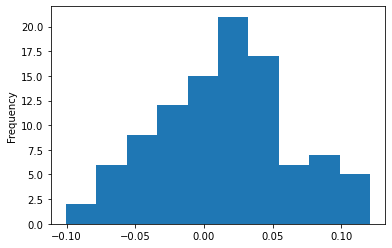

In [14]:
arb_dt.historical_data.pure_returns['index_return'].plot(kind='hist')

In [15]:
arb_dt.historical_data.pure_returns

index_return  basket_return
t                              
0       0.108714       0.098203
1       0.015029       0.030008
2       0.041838       0.058937
3       0.121034       0.122045
4       0.082809       0.103378
..           ...            ...
95      0.040580       0.045329
96      0.018690       0.010525
97      0.099099       0.099294
98      0.037843       0.016346
99      0.041955       0.030099

[100 rows x 2 columns]

Params can be dynamic to allow for different assumptions about what randomness looks like. For example, one set of params might be 

The name is for the name to be given to each series of data. The use_seeds param is whether to use seeds 1...N for setting randomness for reproducibility. The param_values are for the values in parameter setting. 

In [18]:
params1 = {"name": "Normal Distribution",
           "use_seeds": True,
    "param_values": {"index_return": {"type": "Normal Fitted"},
         "basket_return": {"type": "Normal Fitted"}}}

params2 = {"name": "Expert Model",
           "use_seeds": True,
           "param_values": {"index_return": {"type": "Expert Model",
                                      "mu": .01,
                                       "std": .05},
         "basket_return": {"type": "Expert Model",
                          "lambda": .9,
                          "mu": .015,
                          "std": .1}}}

params = [params1, params2]

In [20]:
from abc import ABC, abstractmethod

class StochasticFit(ABC):
    
    def __init__(self, params):
        self.params = params
        
    def fit_data(self, data):
        # Go through each param and get the stochastic fit
        for param in self.params:
            self.fit_param(param, data)
        
    @abstractmethod
    def fit_param(self, param, data):
        pass

In [27]:
class TestStochasticFit(StochasticFit):
    
    def fit_index_return(self, param_value, data):
        print(param_value)
        
    def fit_basket_return(self, param_value, data):
        print(param_value)
        
    def fit_param(self, param, data):
        for pv in param["param_values"]:
            if pv == "index_return":
                fitted = self.fit_index_return(param["param_values"][pv], data)
            elif pv == "basket_return":
                fitted = self.fit_basket_return(param["param_values"][pv], data)
            else:
                raise NotImplementedError

In [28]:
TestDataPipeline = ArbitrageDataPipeline()
TestBacktestModel = BacktestModel()
test_stochastic_fit = TestStochasticFit(params)

arb_dt = ArbitrageDigitalTwin(name = "Test",
                    data_pipeline = TestDataPipeline,
                    backtest_model = TestBacktestModel,
                    stochastic_fit = test_stochastic_fit)
arb_dt.load_data_initial()
arb_dt.compute_input_data()

params_backtest = {}
monte_carlo_runs_backtest = 1

arb_dt.run_backtest(monte_carlo_runs_backtest, params_backtest)


                  ___________    ____
  ________ __ ___/ / ____/   |  / __ \
 / ___/ __` / __  / /   / /| | / / / /
/ /__/ /_/ / /_/ / /___/ ___ |/ /_/ /
\___/\__,_/\__,_/\____/_/  |_/_____/
by cadCAD

cadCAD Version: 0.4.28
Execution Mode: local_proc
Simulation Dimensions:
Entire Simulation: (Models, Unique Timesteps, Params, Total Runs, Sub-States) = (1, 100, 1, 1, 2)
     Simulation 0: (Timesteps, Params, Runs, Sub-States) = (100, 1, 1, 2)
Execution Method: local_simulations
Execution Mode: single_threaded
Total execution time: 0.01s


In [29]:
arb_dt.fit_stochastic_fit()

{'type': 'Normal Fitted'}
{'type': 'Normal Fitted'}
{'type': 'Expert Model', 'mu': 0.01, 'std': 0.05}
{'type': 'Expert Model', 'lambda': 0.9, 'mu': 0.015, 'std': 0.1}
